# Comparison to Neugent & Massey 2010

This paper, "The Spectrum of the Night Sky Over Kitt Peak: Changes Over Two Decades", presents spectra taken at Kitt Peak of the night sky and compares it with other published values over the past two decades. This notebook tries to recreate the plots in that paper to compare the BOSS spectra with what was found.

In [21]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.table
import speclite.filters
import astropy.units as u
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


/global/homes/p/parkerf/.conda/envs/myjupkernel/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
plt.rc('font', size=10, family='serif')

## Kitt Peak Measurements

These are the published magnitudes/arcsec2 reported in the paper. The narrowbands were computed using a constant response over a 100 $\AA$ interval centered on the published wavelength

In [59]:
measurements = astropy.table.Table.read('massey_meas.csv')

In [60]:
measurements

year,cV,cB,V,B,4250,4550,5150
int64,float64,float64,float64,float64,float64,float64,float64
1988,22.07,22.96,21.95,22.84,23.03,22.73,22.32
1999,21.95,22.9,21.72,22.67,22.82,22.64,22.22
2009,21.95,22.79,21.95,22.79,22.96,22.69,22.34


## BOSS Data

The data from the paper was taken on photometric nights during dark time, with observations taken at least 15 deg away from the ecliptic and galactic planes to avoid Zodi and ISL.  The measurements were either made at Zenith or Altitudes of 30deg to test contributions from Terrestrial sources. We don't have data that goes down that far, but we will take some measurements with the altitude lower than 50 deg.

In [4]:
DATA_DIR = '/global/cscratch1/sd/parkerf/sky_flux_corrected'

In [5]:
all_data = astropy.table.Table.read('/global/homes/p/parkerf/Sky/SkyModelling/good_mean_meta.fits')

In [6]:
spectra_meta = astropy.table.Table.read('/global/homes/p/parkerf/Sky/SkyModelling/good_clean_data_180704.fits')

In [7]:
this_data = all_data[(all_data['PHOTO'] == 1)&(all_data['MOON_ALT']<0)&(all_data['SUN_ALT']<-15)&(all_data['GAL_LAT']>15)&(all_data['ECL_LAT']>15)]

In [8]:
zen_data_low = this_data[(this_data['AIRMASS']<1.01)&(this_data['SOLARFLUX']<100)]
zen_data_high = this_data[(this_data['AIRMASS']<1.01)&(this_data['SOLARFLUX']>100)]

Text(0.5,0,'sfu')

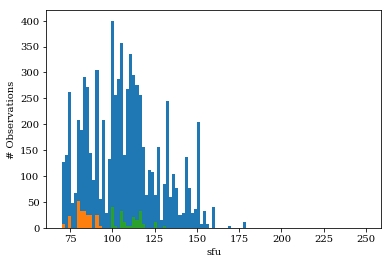

In [89]:
bins = np.linspace(70,250,100)
plt.hist(this_data['SOLARFLUX'],bins=bins,label='all')
plt.hist(zen_data_low['SOLARFLUX'],bins=bins,label='low SF')
plt.hist(zen_data_high['SOLARFLUX'],bins=bins,label='high SF')
plt.ylabel('# Observations')
plt.xlabel("sfu")

In [90]:
print(len(np.unique(zen_data_low['IMG'])))
print(len(np.unique(zen_data_high['IMG'])))

65
47


In [98]:
num_spectra = []
for img in np.unique(zen_data_low['IMG']):
    no = len(spectra_meta[(spectra_meta['IMG'] == img)&(spectra_meta['CAMERAS'] == 'b1')])
    num_spectra.append(no)
print(np.sum(num_spectra))

3143


In [99]:
num_spectra = []
for img in np.unique(zen_data_high['IMG']):
    no = len(spectra_meta[(spectra_meta['IMG'] == img)&(spectra_meta['CAMERAS'] == 'b1')])
    num_spectra.append(no)
print(np.sum(num_spectra))

2205


In [65]:
high_airmass = this_data[this_data['ALT']<45]

In [65]:
# Want to look at mean properties
xx = np.linspace(300, 1040, (1040-300)*100)

In [64]:
def make_mega_mean_spectrum(meta,name):
    SKY_SPECTRA = []
    VARS = []
    for line in meta:
        plate = line['PLATE']
        camera = line['CAMERAS']
        image = line['IMG']
        try:
            SKY_SPECTRA.append(np.load(DATA_DIR+'/mean_spectra/%d/%d_%s_mean_spectrum.npy'% (plate, image, camera)))
            VARS.append(np.load(DATA_DIR+'/mean_spectra/%d/%d_%s_mean_var.npy'% (plate, image, camera)))
        except:
            print(image)
    

    mean_spectrum = np.ma.average(np.array(SKY_SPECTRA), axis=0)
    mean_spectrum.dump(DATA_DIR+'/mean_spectra/%s_%s_zenith_dark_mean_spectrum.npy'% (camera, name))
    return mean_spectrum

In [66]:
low_zenith = {}
for cam in ['b1','b2','r1','r2']:
    meta = zen_data_low[zen_data_low['CAMERAS'] == cam]
    zenith_spectrum = make_mega_mean_spectrum(meta,'low_SF')
    low_zenith[cam] = zenith_spectrum

In [67]:
high_zenith = {}
for cam in ['b1','b2','r1','r2']:
    meta = zen_data_high[zen_data_high['CAMERAS'] == cam]
    zenith_spectrum = make_mega_mean_spectrum(meta,'high_SF')
    high_zenith[cam] = zenith_spectrum

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


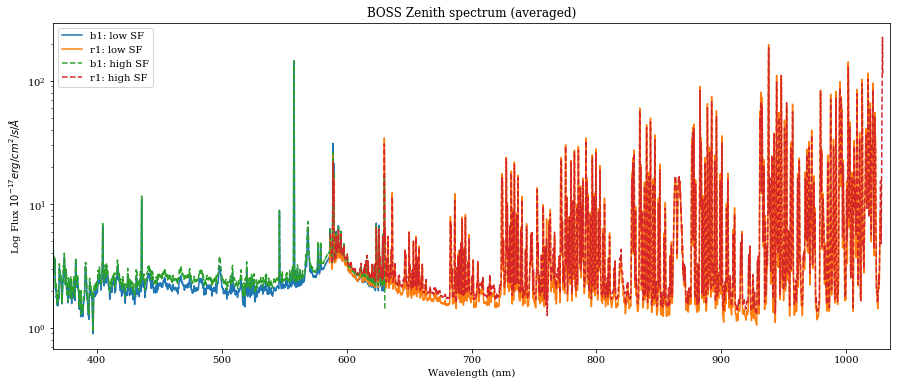

In [115]:
plt.figure(figsize=(15,6))
plt.semilogy(xx, low_zenith['b1'],label = 'b1: low SF')
plt.semilogy(xx, low_zenith['r1'],label = 'r1: low SF')
plt.semilogy(xx, high_zenith['b1'],'--',label='b1: high SF')
plt.semilogy(xx, high_zenith['r1'],'--',label='r1: high SF')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Log Flux $10^{-17} erg/cm^{2}/s/\AA$")
plt.title("BOSS Zenith spectrum (averaged)")
plt.xlim(365,1035)
plt.legend()

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


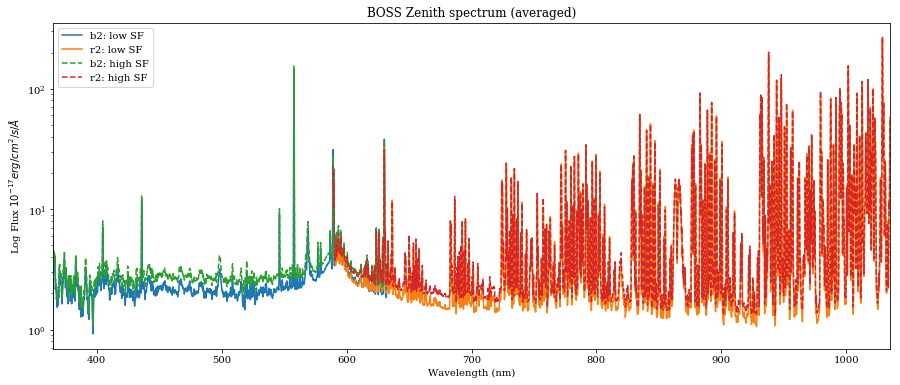

In [116]:
plt.figure(figsize=(15,6))
plt.semilogy(xx, low_zenith['b2'],label = 'b2: low SF')
plt.semilogy(xx, low_zenith['r2'],label = 'r2: low SF')
plt.semilogy(xx, high_zenith['b2'],'--',label='b2: high SF')
plt.semilogy(xx, high_zenith['r2'],'--',label='r2: high SF')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Log Flux $10^{-17} erg/cm^{2}/s/\AA$")
plt.title("BOSS Zenith spectrum (averaged)")
plt.xlim(365,1035)
plt.legend()

## Measure Magnitudes

The Massey papers report B and V magnitudes (/arcsec^{2}), based on the Vega scale, assuming that Vega has a magnitude of 0.03. We compare our zenith results to theirs

In [68]:
fiber_area = np.pi * u.arcsec**2.
fiber_area_sr = fiber_area/4.25e10

In [69]:
blue_data_low = 1e-17*low_zenith['b1']/fiber_area
red_data_low = 1e-17*low_zenith['r1']/fiber_area
blue_data_high = 1e-17*high_zenith['b1']/fiber_area
red_data_high = 1e-17*high_zenith['r1']/fiber_area

(0, 5e-17)

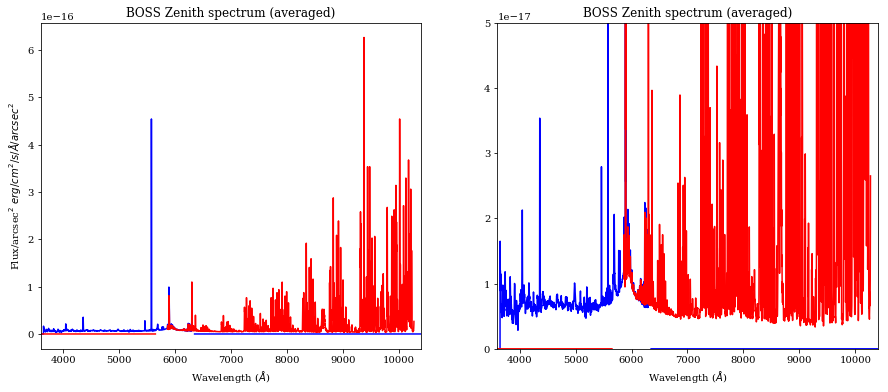

In [119]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
ax = axarr.ravel()
for i in range(2):
    ax[i].plot(xx*10, blue_data,'b-')
    ax[i].plot(xx*10, red_data,'r-')
    ax[i].set_title("BOSS Zenith spectrum (averaged)")
    ax[i].set_xlim(3600,10400)
    ax[i].set_xlabel("Wavelength ($\AA$)")
ax[0].set_ylabel("Flux/arcsec$^{2}$ $erg/cm^{2}/s/\AA/arcsec^{2}$")
ax[1].set_ylim(0,5e-17)

### Filters

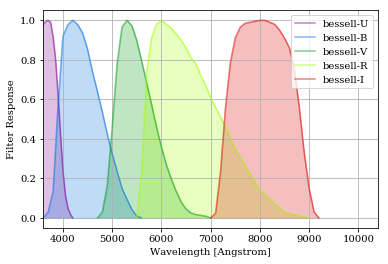

In [120]:
bessell_B = speclite.filters.load_filter('bessell-B')
bessell_V = speclite.filters.load_filter('bessell-V')
bessell = speclite.filters.load_filters('bessell-*')
speclite.filters.plot_filters(bessell, wavelength_limits=(3600, 10400))

In [122]:
sdss_filters = speclite.filters.load_filters('sdss2010-*')

In [71]:
Vega = astropy.table.Table.read('ftp://ftp.stsci.edu/cdbs/current_calspec/alpha_lyr_stis_008.fits')

Text(0.5,0,'Wavelength ($\\AA$))')

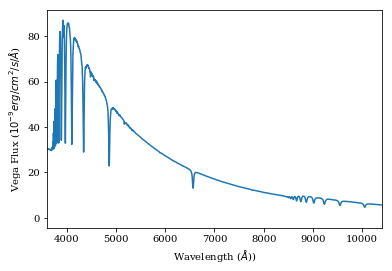

In [63]:
plt.plot(Vega['WAVELENGTH'], Vega['FLUX']*10e9)
plt.xlim(3600,10400)
plt.ylabel("Vega Flux ($10^{-9} erg/cm^{2}/s/\AA$)")
plt.xlabel("Wavelength ($\AA$))")

In [72]:
vegawave, vegaflux = np.array(Vega["WAVELENGTH"]), np.array(Vega['FLUX'])
vega = interp1d(vegawave, vegaflux, bounds_error=False, fill_value = 0)

In [73]:
kp_blue = np.genfromtxt('ftp://ftp.lowell.edu/pub/massey/Sky1.txt')
kp_red = np.genfromtxt('ftp://ftp.lowell.edu/pub/massey/Sky2.txt')

/global/homes/p/parkerf/.conda/envs/myjupkernel/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/homes/p/parkerf/.conda/envs/myjupkernel/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/p/parkerf/.conda/envs/myjupkernel/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/global/homes/p/parkerf/.conda/envs/myjupkernel/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


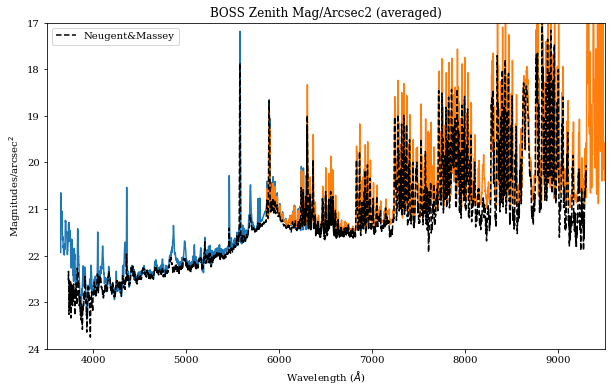

In [79]:
plt.figure(figsize = (10,6))
mb1 = -2.5 * np.log10(blue_data_low/vega(xx*10))
mr1 = -2.5 * np.log10(red_data_low/vega(xx*10))
mb2 = -2.5 * np.log10(blue_data_high/vega(xx*10))
mr2 = -2.5 * np.log10(red_data_high/vega(xx*10))
plt.plot(xx*10, mb1)
plt.plot(xx*10, mr1)
#plt.plot(xx*10, mb2,label = 'high SF')
#plt.plot(xx*10, mr2, label = 'high SF')
plt.plot(kp_blue[:,0],kp_blue[:,1],'k--',label = 'Neugent&Massey' )
plt.plot(kp_red[:,0],kp_red[:,1],'k--')

plt.title("BOSS Zenith Mag/Arcsec2 (averaged)")
plt.ylabel("Magnitudes/arcsec$^{2}$")
plt.xlabel("Wavelength ($\AA$)")
plt.ylim(24,17)
plt.xlim(3500,9500)
plt.legend()

In [127]:
# Need to remove 5577 line
def remove_OI(data):
    wave_range = xx*10
    id0 = np.where((wave_range>(5577-20))&(wave_range<(5577-17)))
    id1 = np.where((wave_range<(5577+20))&(wave_range>(5577+17)))

    idx = np.where((wave_range>(5577-17))&(wave_range<(5577+17)))
    mean1 = np.mean(data[id0])
    mean2 = np.mean(data[id1])
    mean = np.mean([mean1,mean2])
    data[idx] = mean
    return data

In [56]:
def get_narrow_band_mag(spectrum, wavelength):
    idx = np.where((wave_range>wavelength-50)&(wave_range>wavelength+50))
    
    band = np.mean(spectrum[idx])
    v = np.mean(vega(wave_range)[idx])
    
    M = -2.5 * np.log10(band/v)
    return M

In [57]:
def get_vmag(ff, flux):
    znum = ff.convolve_with_array(wave_range, vega(wave_range))
    zden = ff.convolve_with_function(lambda wlen: u.Quantity(1))
    zp = (znum/zden)
    
    mnum = ff.convolve_with_array(wave_range, flux)
    mden = ff.convolve_with_function(lambda wlen: u.Quantity(1))
    mp = (mnum/mden)
    
    M = -2.5 * np.log10(mp/zp)
    return M

In [128]:
for filt in bessell:
    m = get_vmag(filt, remove_OI(blue_data_low))
    print("%s: %.2f" % (filt.name, m))

bessell-U: 22.74
bessell-B: 22.37
bessell-V: 21.62
bessell-R: 21.84
bessell-I: inf


/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


In [130]:
def get_mags(data):
    mm = []
    for filt in bessell:
        mm.append(get_vmag(filt, remove_OI(data)))
    for w in [4250, 4550,5150]:
        mm.append(get_narrow_band_mag(data, w))
    return mm

In [139]:
M = {}
names = ['blue_low', 'blue_high', 'red_low', 'red_high']
for i, data in enumerate([blue_data_low, blue_data_high, red_data_low, red_data_high]):
    M[names[i]]=get_mags(data)

/global/common/software/desi/cori/desiconda/20180130-1.2.4-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


In [146]:
import pandas as pd
df = pd.DataFrame.from_dict(M,orient='index')
df.columns = ['U','B','V','R','I',4250,4550,5150]
df

,U,B,V,R,I,4250,4550,5150
blue_low,22.741403992719572,22.365720305522174,21.615805672165727,21.842402450592942,inf,22.228519,22.216631,22.247379
blue_high,22.679443731101255,22.217487481701262,nan,nan,inf,22.096009,22.088203,22.141187
red_low,inf,inf,22.97415008448197,20.854547325065575,19.45530466537777,20.207910,20.037307,19.697893
red_high,inf,inf,22.932513130198338,20.802628229730633,19.449824319771643,20.174843,20.004391,19.665332


In [61]:
measurements

year,cV,cB,V,B,4250,4550,5150
int64,float64,float64,float64,float64,float64,float64,float64
1988,22.07,22.96,21.95,22.84,23.03,22.73,22.32
1999,21.95,22.9,21.72,22.67,22.82,22.64,22.22
2009,21.95,22.79,21.95,22.79,22.96,22.69,22.34


## Look at Distribution

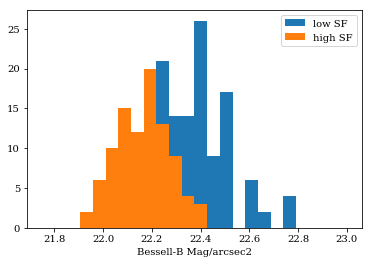

In [152]:
bins = np.linspace(21.75,23,25)
blue_zen_low = zen_data_low[(zen_data_low['CAMERAS'] == 'b1')|(zen_data_low['CAMERAS'] == 'b2')]
blue_zen_high = zen_data_high[(zen_data_high['CAMERAS'] == 'b1')|(zen_data_high['CAMERAS'] == 'b2')]
plt.hist(blue_zen_low['bessell-B'],bins=bins,label = 'low SF')
plt.hist(blue_zen_high['bessell-B'],bins=bins, label = 'high SF')
#plt.text(22.3,15,"Mean: %.2f"% bmean)
plt.xlabel('Bessell-B Mag/arcsec2')
plt.legend()

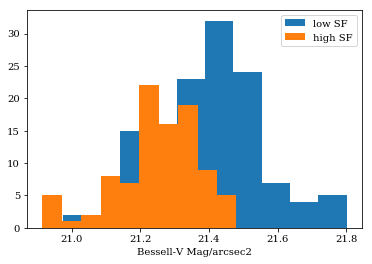

In [154]:
#bins = np.linspace(21.75,23,25)
blue_zen_low = zen_data_low[(zen_data_low['CAMERAS'] == 'b1')|(zen_data_low['CAMERAS'] == 'b2')]
blue_zen_high = zen_data_high[(zen_data_high['CAMERAS'] == 'b1')|(zen_data_high['CAMERAS'] == 'b2')]
plt.hist(blue_zen_low['bessell-V'],label = 'low SF')
plt.hist(blue_zen_high['bessell-V'], label = 'high SF')
#plt.text(22.3,15,"Mean: %.2f"% bmean)
plt.xlabel('Bessell-V Mag/arcsec2')
plt.legend()

### Spectra through the year

Find a plate that was used several times in a year to compare change over the year. There isn't a good example that's part of the zenith data so we open it up to all data

In [38]:
zen_data_low['rHOUR'] = astropy.table.Column(np.round(zen_data_low['HOUR']))
zen_data_high['rHOUR'] = astropy.table.Column(np.round(zen_data_high['HOUR']))

In [39]:
zen_blue_low = zen_data_low[(zen_data_low['CAMERAS'] == 'b1')|(zen_data_low['CAMERAS'] == 'b2')]
zen_red_low = zen_data_low[(zen_data_low['CAMERAS'] == 'r1')|(zen_data_low['CAMERAS'] == 'r2')]
zen_blue_high = zen_data_high[(zen_data_high['CAMERAS'] == 'b1')|(zen_data_high['CAMERAS'] == 'b2')]
zen_red_high = zen_data_high[(zen_data_high['CAMERAS'] == 'r1')|(zen_data_high['CAMERAS'] == 'r2')]

In [35]:
def month_plot(data,name,cam):
    Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    DATA = {}
    for month in np.unique(data['MONTH']):
        D = []
        seeing = []
        airmass = []
        sf = []
        month_data = data[data['MONTH'] == month]
        for line in month_data:
            plate = line['PLATE']
            camera = line['CAMERAS']
            image = line['IMG']
            seeing.append(line['SEEING50'])
            airmass.append(line['AIRMASS'])
            sf.append(line['SOLARFLUX'])
            D.append(np.load(DATA_DIR+'/mean_spectra/%d/%d_%s_mean_spectrum.npy'% (plate, image, camera)))
        mean = np.average(D, axis=0)
        DATA[month] = mean
        print("%s (%d): seeing %.2f, airmass %.2f, solarflux %.2f"%(Months[month-1],len(month_data),np.mean(seeing),np.mean(airmass),np.mean(sf)))

    plt.figure(figsize = (10,6))

    for key, spectrum in DATA.items():
        month = Months[key-1]
        plt.semilogy(xx, spectrum, label = month,linewidth=0.5)
    plt.legend()

    plt.title(name)
    plt.ylim(pow(10,0),pow(10,3))
    if cam == 'blue':
        plt.xlim(360,635)
    elif cam == 'red':
        plt.xlim(575,1040)

Jan (6): seeing 1.79, airmass 1.00, solarflux 79.29
Feb (72): seeing 1.57, airmass 1.01, solarflux 86.72
Mar (10): seeing 1.56, airmass 1.01, solarflux 90.90
Apr (11): seeing 1.35, airmass 1.01, solarflux 73.75
May (22): seeing 1.37, airmass 1.01, solarflux 76.55
Jul (6): seeing 1.69, airmass 1.01, solarflux 86.48
Nov (2): seeing 1.45, airmass 1.00, solarflux 85.21


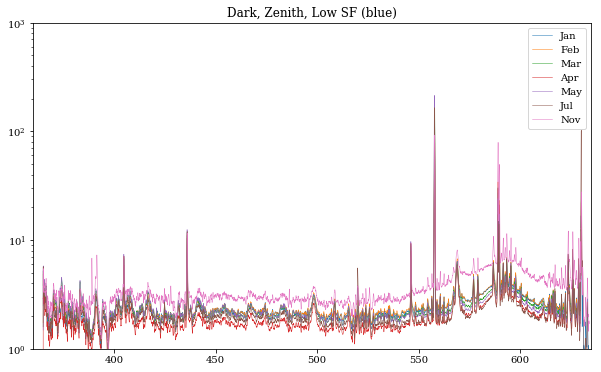

In [33]:
month_plot(zen_blue_low,'Dark, Zenith, Low SF (blue)','blue')

Feb (44): seeing 1.69, airmass 1.01, solarflux 103.35
Mar (36): seeing 1.66, airmass 1.00, solarflux 115.97
Apr (8): seeing 1.61, airmass 1.01, solarflux 114.54
May (2): seeing 1.76, airmass 1.01, solarflux 130.93
Jun (4): seeing 1.48, airmass 1.01, solarflux 125.46


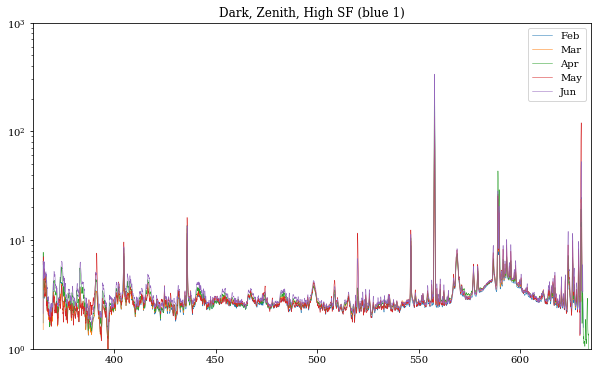

In [32]:
month_plot(zen_blue_high,'Dark, Zenith, High SF (blue 1)','blue')

Jan (6): seeing 1.79, airmass 1.00, solarflux 79.29
Feb (72): seeing 1.57, airmass 1.01, solarflux 86.72
Mar (10): seeing 1.56, airmass 1.01, solarflux 90.90
Apr (11): seeing 1.35, airmass 1.01, solarflux 73.75
May (22): seeing 1.37, airmass 1.01, solarflux 76.55
Jul (6): seeing 1.69, airmass 1.01, solarflux 86.48
Nov (2): seeing 1.45, airmass 1.00, solarflux 85.21


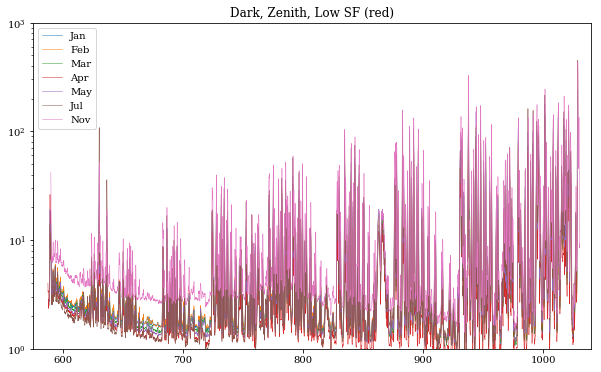

In [36]:
month_plot(zen_red_low,'Dark, Zenith, Low SF (red)','red')

Feb (44): seeing 1.69, airmass 1.01, solarflux 103.35
Mar (36): seeing 1.66, airmass 1.00, solarflux 115.97
Apr (8): seeing 1.61, airmass 1.01, solarflux 114.54
May (2): seeing 1.76, airmass 1.01, solarflux 130.93
Jun (4): seeing 1.48, airmass 1.01, solarflux 125.46


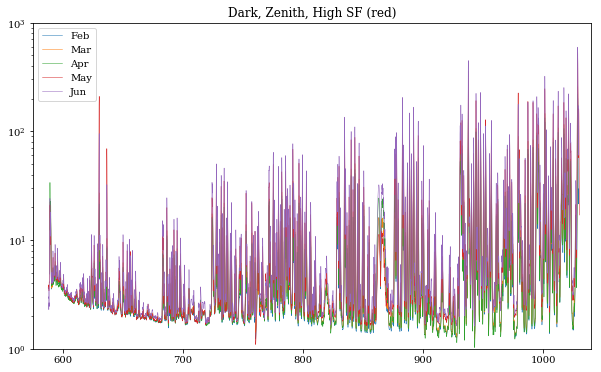

In [37]:
month_plot(zen_red_high,'Dark, Zenith, High SF (red)','red')

### Over a night

In [53]:
def hour_plot(data,name,cam):
    DATA = {}
    for hour in np.unique(data['rHOUR']):
        D = []
        seeing = []
        airmass = []
        sf = []
        month_data = data[data['rHOUR'] == hour]
        for line in month_data:
            plate = line['PLATE']
            camera = line['CAMERAS']
            image = line['IMG']
            seeing.append(line['SEEING50'])
            airmass.append(line['AIRMASS'])
            sf.append(line['SOLARFLUX'])
            D.append(np.load(DATA_DIR+'/mean_spectra/%d/%d_%s_mean_spectrum.npy'% (plate, image, camera)))
        mean = np.average(D, axis=0)
        DATA[hour] = mean
        print("%s (%d): seeing %.2f, airmass %.2f, solarflux %.2f"%(hour,len(month_data),np.mean(seeing),np.mean(airmass),np.mean(sf)))

    plt.figure(figsize = (10,6))

    for key, spectrum in DATA.items():
        if (key>2)&(key<10):
            plt.semilogy(xx, spectrum, label = key,linewidth=0.5)
    plt.legend()

    plt.title(name)
    plt.ylim(pow(10,0),pow(10,1))
    if cam == 'blue':
        plt.xlim(360,635)
    elif cam == 'red':
        plt.xlim(575,1040)

2.0 (2): seeing 1.70, airmass 1.00, solarflux 86.48
3.0 (14): seeing 1.56, airmass 1.01, solarflux 80.95
4.0 (8): seeing 1.36, airmass 1.01, solarflux 74.88
5.0 (8): seeing 0.85, airmass 1.01, solarflux 78.69
6.0 (2): seeing 2.06, airmass 1.01, solarflux 90.24
7.0 (30): seeing 1.96, airmass 1.01, solarflux 86.16
8.0 (21): seeing 1.60, airmass 1.01, solarflux 83.02
9.0 (18): seeing 1.81, airmass 1.00, solarflux 86.33
10.0 (14): seeing 1.23, airmass 1.00, solarflux 83.85
11.0 (10): seeing 0.53, airmass 1.01, solarflux 87.17
12.0 (2): seeing 1.45, airmass 1.00, solarflux 85.21


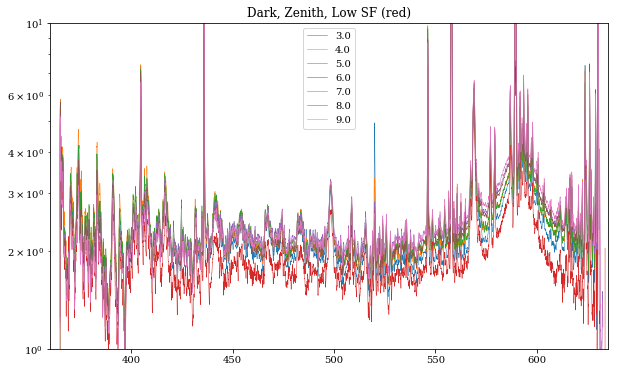

In [54]:
hour_plot(zen_blue_low,'Dark, Zenith, Low SF (red)','blue')

2.0 (2): seeing 1.76, airmass 1.01, solarflux 130.93
3.0 (8): seeing 1.60, airmass 1.01, solarflux 122.15
4.0 (2): seeing 1.43, airmass 1.01, solarflux 111.12
5.0 (4): seeing 1.35, airmass 1.01, solarflux 117.00
6.0 (10): seeing 1.77, airmass 1.00, solarflux 115.36
7.0 (26): seeing 1.71, airmass 1.01, solarflux 111.81
8.0 (16): seeing 1.70, airmass 1.01, solarflux 106.59
9.0 (16): seeing 1.71, airmass 1.01, solarflux 103.39
10.0 (8): seeing 1.56, airmass 1.01, solarflux 106.32
11.0 (2): seeing 1.40, airmass 1.00, solarflux 100.89


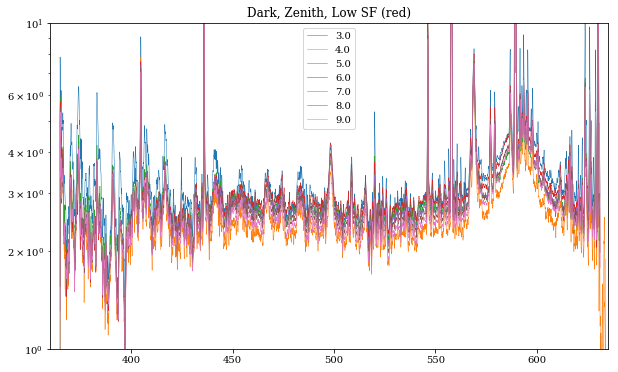

In [55]:
hour_plot(zen_blue_high,'Dark, Zenith, Low SF (red)','blue')

2.0 (2): seeing 1.70, airmass 1.00, solarflux 86.48
3.0 (14): seeing 1.56, airmass 1.01, solarflux 80.95
4.0 (8): seeing 1.36, airmass 1.01, solarflux 74.88
5.0 (8): seeing 0.85, airmass 1.01, solarflux 78.69
6.0 (2): seeing 2.06, airmass 1.01, solarflux 90.24
7.0 (30): seeing 1.96, airmass 1.01, solarflux 86.16
8.0 (21): seeing 1.60, airmass 1.01, solarflux 83.02
9.0 (18): seeing 1.81, airmass 1.00, solarflux 86.33
10.0 (14): seeing 1.23, airmass 1.00, solarflux 83.85
11.0 (10): seeing 0.53, airmass 1.01, solarflux 87.17
12.0 (2): seeing 1.45, airmass 1.00, solarflux 85.21


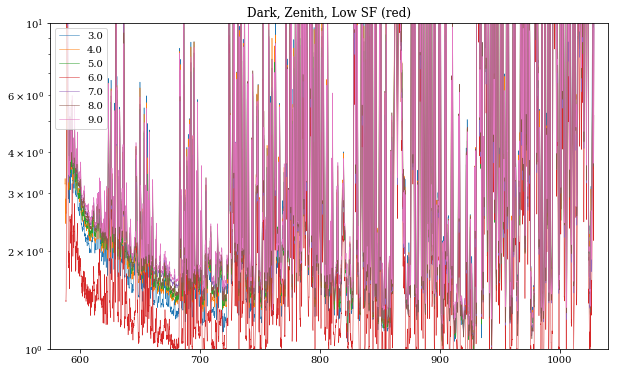

In [56]:
hour_plot(zen_red_low,'Dark, Zenith, Low SF (red)','red')

2.0 (2): seeing 1.76, airmass 1.01, solarflux 130.93
3.0 (8): seeing 1.60, airmass 1.01, solarflux 122.15
4.0 (2): seeing 1.43, airmass 1.01, solarflux 111.12
5.0 (4): seeing 1.35, airmass 1.01, solarflux 117.00
6.0 (10): seeing 1.77, airmass 1.00, solarflux 115.36
7.0 (26): seeing 1.71, airmass 1.01, solarflux 111.81
8.0 (16): seeing 1.70, airmass 1.01, solarflux 106.59
9.0 (16): seeing 1.71, airmass 1.01, solarflux 103.39
10.0 (8): seeing 1.56, airmass 1.01, solarflux 106.32
11.0 (2): seeing 1.40, airmass 1.00, solarflux 100.89


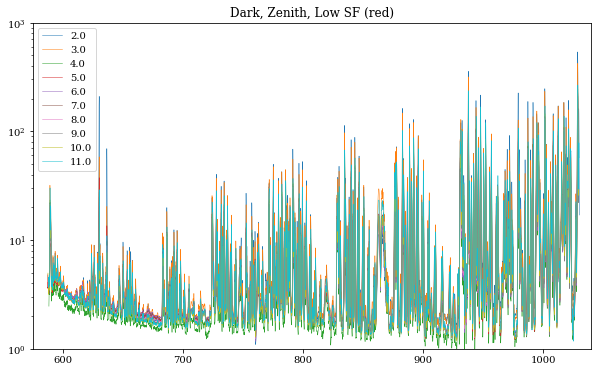

In [50]:
hour_plot(zen_red_high,'Dark, Zenith, Low SF (red)','red')